In [7]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

Define some global variables

In [8]:
# training batches of our network
EPOCHS = 10
# size of each batch
BATCH_SIZE = 512

DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(torch.__version__)
print(DEVICE)

1.9.0+cu102
cuda


# Load data

In [9]:
train_csv = pd.read_csv('/content/fashion-mnist_train.csv')
test_csv = pd.read_csv('/content/fashion-mnist_test.csv')


print(train_csv.shape)
print(test_csv.shape)

(60000, 785)
(10000, 785)


In [ ]:
print(train_csv.info())
print(train_csv.head())

As the output, the first row is the label of each image, and each image has 784 pixels

## Dataset

In [11]:
class FashionDataset(Dataset):
    def __init__(self, data, transform=None):        
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label, image = [], []
        
        for i in self.fashion_MNIST:
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28).astype('float32')
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]      
        
        if self.transform is not None:
            # transfrom the numpy array to PIL image before the transform function
            pil_image = Image.fromarray(np.uint8(image)) 
            image = self.transform(pil_image)
            
        return image, label

## Transform

Because the input size of AlexNet is $227*227$, and the image size of Fashion-MNIST is $28*28$, so we need to resize the image in the transform function
> Since `transforms.Resize()` only works to the PIL Image,we transform the numpy array to PIL Image above

In [12]:
AlexTransform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## DataLoader

In [13]:
train_loader = DataLoader(
    FashionDataset(train_csv, transform=AlexTransform), 
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(
    FashionDataset(test_csv, transform=AlexTransform), 
    batch_size=BATCH_SIZE, shuffle=True)

## Show images

Coat


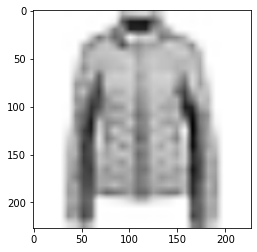

In [14]:
# helper function to show an image
def matplotlib_imshow(img):
    img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg, cmap="Greys")

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# creat grid of images
img_grid = torchvision.utils.make_grid(images[0])

# show images & labels
matplotlib_imshow(img_grid)
print(class_names[labels[0]])

# AlexNet

![](https://i.loli.net/2020/02/17/xd6oNRpWSK1cZy2.png)

In [15]:
class fasion_mnist_alexnet(nn.Module):  
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )

        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)

        out = F.relu(self.fc1(out))  # 256*6*6 -> 4096
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)

        return out


# model


In [16]:
model = fasion_mnist_alexnet().to(DEVICE)
criterion = F.nll_loss
optimizer = optim.Adam(model.parameters())

## train function

In [17]:
def train(model, device, train_loader, optimer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 30 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

## test function


In [18]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)  # loss之和除以data数量 -> mean
        print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        print('='*50)


# Begin to Train

In [19]:
for epoch in range(1, EPOCHS+1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch:1 [14848/60000 (25%)]	Loss: 1.044988
Train Epoch:1 [30208/60000 (50%)]	Loss: 0.676964
Train Epoch:1 [45568/60000 (75%)]	Loss: 0.582765

Test set: Average loss: 0.4492, Accuracy: 8359/10000 (84%)

Train Epoch:2 [14848/60000 (25%)]	Loss: 0.423430
Train Epoch:2 [30208/60000 (50%)]	Loss: 0.351235
Train Epoch:2 [45568/60000 (75%)]	Loss: 0.331135

Test set: Average loss: 0.3238, Accuracy: 8799/10000 (88%)

Train Epoch:3 [14848/60000 (25%)]	Loss: 0.346332
Train Epoch:3 [30208/60000 (50%)]	Loss: 0.263105
Train Epoch:3 [45568/60000 (75%)]	Loss: 0.276527

Test set: Average loss: 0.2842, Accuracy: 8932/10000 (89%)

Train Epoch:4 [14848/60000 (25%)]	Loss: 0.268081
Train Epoch:4 [30208/60000 (50%)]	Loss: 0.212477
Train Epoch:4 [45568/60000 (75%)]	Loss: 0.263545

Test set: Average loss: 0.2668, Accuracy: 9000/10000 (90%)

Train Epoch:5 [14848/60000 (25%)]	Loss: 0.258846
Train Epoch:5 [30208/60000 (50%)]	Loss: 0.261112
Train Epoch:5 [45568/60000 (75%)]	Loss: 0.238090

Test set: Average lo